<a href="https://colab.research.google.com/github/LeNovice/PSW/blob/main/Main_CadenceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: Refer

https://debuggercafe.com/getting-95-accuracy-on-the-caltech101-dataset-using-deep-learning/

Data Pipeline:
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator

https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map

Loading the Caltech Dataset

In [75]:
import tensorflow_datasets as tfds
import numpy as np
#For plotting the dataset
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
#Data pipeline preparation
import tensorflow as tf
from tensorflow.keras import layers
#model buildingZ
from tensorflow.keras import models

In [76]:
(ds, ds_info) = tfds.load('caltech101', with_info=True, as_supervised=True)

In [77]:
ds_train, train_info = ds["train"], ds_info.splits['train']
ds_test, test_info = ds["test"], ds_info.splits['test']
display(train_info.num_examples)
display(test_info.num_examples)

3060

6084

Initially we will only try to train for 10 classes.

https://github.com/tensorflow/datasets/issues/1923#issuecomment-1361608072

In [78]:
def filter_fn(x, allowed_classes:list):
    allowed_classes = tf.constant(allowed_classes)
    isallowed = tf.equal(allowed_classes, tf.cast(x, allowed_classes.dtype))
    reduced_sum = tf.reduce_sum(tf.cast(isallowed, tf.float32))
    return tf.greater(reduced_sum, tf.constant(0.))

#dataset.filter(lambda s: filter_classes(s['label'], [0,1,2]))
class_list = [0,1,2,3,4,5,6,7,8,9]
filtered_ds_train = ds_train.filter(lambda x, y: filter_fn(y, class_list)) # as_supervised
filtered_ds_test = ds_test.filter(lambda x, y: filter_fn(y, class_list))

Data Preprocessing

We could use adapt() methods to get normlazation (feature wise) parameters. https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method

https://stackoverflow.com/questions/57657386/tensorflow-datasets-reshape-images


MAINLY:
https://www.tensorflow.org/datasets/keras_example

In [79]:
#Hyperparameters
IMG_SIZE = 224
NUM_CHANNELS = 3
BATCH_SIZE=128
NUM_CLASSES = len(class_list)

Resizing and re-scaling images to a given dataset.
Tutorial used: https://www.tensorflow.org/tutorials/images/data_augmentation

For data pipeline you may also refer to
https://github.com/tensorflow/datasets/issues/720

In [80]:
def map_func(image, label):
    resized_image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE, IMG_SIZE)        #TODO: Remove crop as muh as possible
    return resized_image, label

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

#buffer_size = ds_info.splits['train'].num_examples      #Might return -2   https://stackoverflow.com/questions/50737192/tf-data-dataset-how-to-get-the-dataset-size-number-of-elements-in-an-epoch
buffer_size = 30*NUM_CLASSES

#resized_ds_train = filtered_ds_train.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)
#https://www.tensorflow.org/tutorials/images/data_augmentation#apply_the_preprocessing_layers_to_the_datasets
def prepare(ds, shuffle=False, augment=False):
    global buffer_size
    global BATCH_SIZE

    # Resize and rescale all datasets.
    #ds = ds.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(buffer_size)
        
    # Batch all datasets.
    #ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set.
    if augment:
        ds_aug = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.concatenate(ds_aug)

        
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [81]:
resized_ds_train = prepare(filtered_ds_train, augment=True)
resized_ds_test = prepare(filtered_ds_test)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

<tf.Tensor: shape=(), dtype=int64, numpy=8>

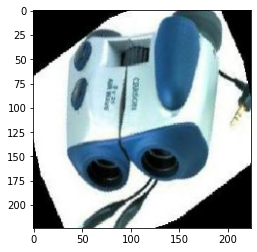

In [82]:
input_shape = ()
display(type(resized_ds_train))
for example in resized_ds_train:
    image, label = example[0], example[1]
    plt.imshow(image)
    display(label)
    input_shape = image.shape
    break
plt.show()

display few examples

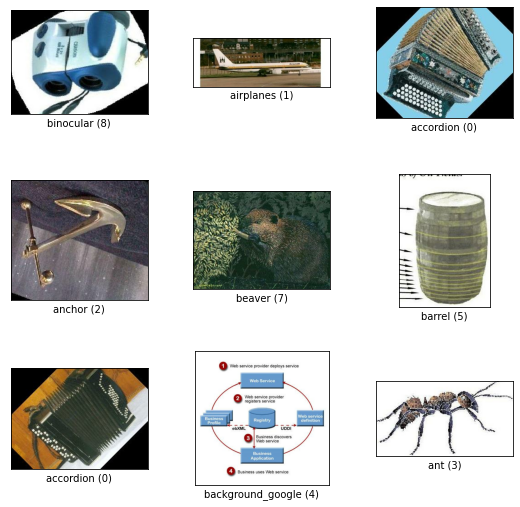

In [83]:
fig = tfds.show_examples(filtered_ds_train, ds_info)

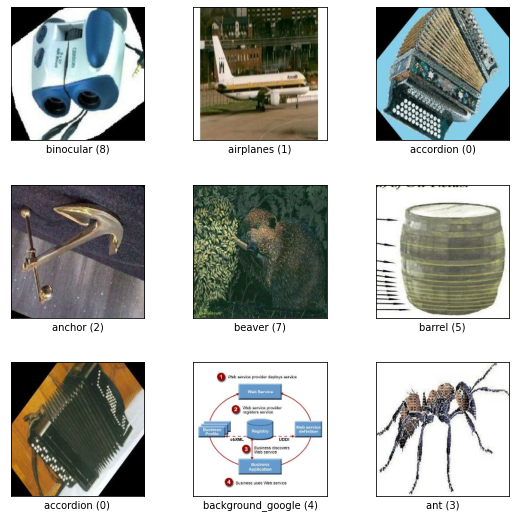

In [84]:
#ds_example = ds_train.take(10)
fig = tfds.show_examples(resized_ds_train, ds_info)

Prepare the model
For Batchnorm, refer https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization

Here they say that During training, the layer normalizes its output using the mean and standard deviation of the **current batch** of inputs.

In order to make BatchNorm great, should we be using a larger batch as input?

However, during Inference mode, the mean ans tsd deviation does not correspond to the current batch. Rather it is a moving mean and std dev of all the bacthes seen in training phase. (Thus, the parameters in inference phase for batch norm do not change)

In [85]:
model = models.Sequential()
#model.add(resize_and_rescale)

kernel_size = (5,5)
model.add(layers.Conv2D(64, kernel_size, input_shape = input_shape))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

kernel_size = (3,3)
model.add(layers.Conv2D(192, kernel_size))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

kernel_size = (3,3)
model.add(layers.Conv2D(64, kernel_size))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

kernel_size = (3,3)
model.add(layers.Conv2D(128, kernel_size))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

model.add(layers.Flatten())
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

In [86]:
Learning_Rate = 1e-1                                            #https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
opt = tf.keras.optimizers.Adam(learning_rate=Learning_Rate)     #OR tf.keras.optimizers.SGD(learning_rate=Learning_Rate, momentum=0.0)
model.compile( optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'] )

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 220, 220, 64)      4864      
                                                                 
 batch_normalization_20 (Bat  (None, 220, 220, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 108, 108, 192)     110784    
                                                                 
 batch_normalization_21 (Bat  (None, 108, 108, 192)    768       
 chNormalization)                                                
                                                     

Reference: https://github.com/tensorflow/datasets/issues/720

In [87]:
#resized_ds_train = resized_ds_train.cache()

#resized_ds_train = resized_ds_train.shuffle(buffer_size)
resized_ds_train = resized_ds_train.batch(BATCH_SIZE)
resized_ds_test = resized_ds_test.batch(BATCH_SIZE)
#resized_ds_train = resized_ds_train.prefetch(tf.data.AUTOTUNE)

Augmentation (Not part of model)

In [88]:
h = model.fit( resized_ds_train, epochs=50)

Epoch 1/50
5/5 [==============================] - 6s 1s/step - loss: 296.6087 - accuracy: 0.1250
Epoch 2/50
5/5 [==============================] - 4s 884ms/step - loss: 296.6577 - accuracy: 0.1967
Epoch 3/50
5/5 [==============================] - 4s 879ms/step - loss: 173.6902 - accuracy: 0.2167
Epoch 4/50
5/5 [==============================] - 4s 867ms/step - loss: 89.2987 - accuracy: 0.2700
Epoch 5/50
5/5 [==============================] - 4s 870ms/step - loss: 70.6814 - accuracy: 0.1517
Epoch 6/50
5/5 [==============================] - 4s 882ms/step - loss: 46.7187 - accuracy: 0.2483
Epoch 7/50
5/5 [==============================] - 4s 892ms/step - loss: 33.6113 - accuracy: 0.2517
Epoch 8/50
5/5 [==============================] - 4s 889ms/step - loss: 25.2931 - accuracy: 0.3033
Epoch 9/50
5/5 [==============================] - 4s 883ms/step - loss: 20.8871 - accuracy: 0.2767
Epoch 10/50
5/5 [==============================] - 4s 875ms/step - loss: 17.2808 - accuracy: 0.2383
Epoch 11/

In [89]:
loss,acc = model.evaluate(resized_ds_test)

12/12 [==============================] - 4s 342ms/step - loss: 1.7804 - accuracy: 0.5283
